In [15]:
import pandas as pd
df = pd.read_csv("ObesityDataSet_raw_and_data_sinthetic.csv")
df

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.000000,1.620000,64.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,0.000000,1.000000,no,Public_Transportation,Normal_Weight
1,Female,21.000000,1.520000,56.000000,yes,no,3.0,3.0,Sometimes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.000000,1.800000,77.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,2.000000,1.000000,Frequently,Public_Transportation,Normal_Weight
3,Male,27.000000,1.800000,87.000000,no,no,3.0,3.0,Sometimes,no,2.000000,no,2.000000,0.000000,Frequently,Walking,Overweight_Level_I
4,Male,22.000000,1.780000,89.800000,no,no,2.0,1.0,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,yes,yes,3.0,3.0,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
2107,Female,21.982942,1.748584,133.742943,yes,yes,3.0,3.0,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
2108,Female,22.524036,1.752206,133.689352,yes,yes,3.0,3.0,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
2109,Female,24.361936,1.739450,133.346641,yes,yes,3.0,3.0,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III


ーーー
↓


論文の説明によるとNObeyesdadは体重と身長のみで計算されている。
つまり体重と身長のみで説明されるので、これからの分析にこの二つの特徴量を入れるのは適していない。多重共線性が出る可能性が限りなく高まる。

肥満との関連している要因は３つある。
身体的特徴・食習慣・生活習慣だ。

上の説明の通り、身体的特徴があまりに肥満に大きな影響を与えている（当たり前すぎる話）
そこで、今回の分析では食習慣と生活習慣の中の変数のうち、何の変数が肥満度に大きな影響を与えているのかを見ていく。

つまり、これからの分析では身体的特徴を除外する。


ーーー

In [16]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

# データの読み込み
# df = pd.read_csv("your_dataset.csv")  # データを読み込む（適宜パスを指定）

# 身体的特徴を除外
X = df.drop(columns=['Gender', 'Age', 'Height', 'Weight', 'NObeyesdad'])

# ターゲット変数
y = df['NObeyesdad']

# カテゴリ変数のダミー変数化
X = pd.get_dummies(X, drop_first=True)

# ターゲット変数の順序付け（例: 不十分な体重～肥満タイプIII）
y_ordered = y.astype('category').cat.reorder_categories(
    ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 
     'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 
     'Obesity_Type_III'], ordered=True
)


ーーー


ここからは、順序回帰、決定着分析、ランダムフォレストの３つの分析手法を試していく。

これらの結果から、共通すること・分析手法によって結果が異なる場合などの事を考慮しながら解釈していく



ーーー

In [17]:
# 順序回帰モデル
model = OrderedModel(y_ordered, X, distr='logit')

# モデルの適合
result = model.fit(method='bfgs')

# 結果の表示
print(result.summary())


Optimization terminated successfully.
         Current function value: 1.606598
         Iterations: 116
         Function evaluations: 117
         Gradient evaluations: 117
                             OrderedModel Results                             
Dep. Variable:             NObeyesdad   Log-Likelihood:                -3391.5
Model:                   OrderedModel   AIC:                             6833.
Method:            Maximum Likelihood   BIC:                             6974.
Date:                Tue, 14 Jan 2025                                         
Time:                        13:58:00                                         
No. Observations:                2111                                         
Df Residuals:                    2086                                         
Df Model:                          25                                         
                                             coef    std err          z      P>|z|      [0.025      0.975]
-------

↑
↑
↑
まずは、順序回帰分析の解釈を見ていく

P値 (P>|z|)
各変数が有意であるかを示します。
P値 < 0.05: 統計的に有意 → 説明変数が目的変数に有意な影響を与えている。
P値 ≥ 0.05: 統計的に有意でない → この変数の影響は弱い可能性。


有意な変数の例
FCVC (Frequent Consumption of Vegetables and Fruits):
係数: 1.0917 (P値 < 0.05)
→ 野菜と果物の頻繁な摂取は、より高い肥満レベルのカテゴリの確率を増加させ
る。


NCP (Number of Meals per Day):
係数: 0.1340 (P値 < 0.05)
→ 1日の食事回数が増えると、より高い肥満レベルのカテゴリの確率が増加。


CH2O (Daily Water Consumption):
係数: 0.2118 (P値 < 0.05)
→ 水の摂取量が多いほど、高いカテゴリの確率が増加。


FAF (Physical Activity Frequency):
係数: -0.4237 (P値 < 0.05)
→ 身体活動の頻度が高いほど、より低い肥満カテゴリの確率が増加。


Family History of Overweight (Yes):
係数: 2.4222 (P値 < 0.05)
→ 肥満の家族歴がある場合、より高い肥満カテゴリの確率が大幅に増加。



有意でない変数の例

SMOKE (Smoking Habit):
係数: 0.2904 (P値 = 0.280)
→ 喫煙の影響は統計的に有意ではない。


CALC (Caloric Food Consumption):
いずれのカテゴリでも P値 > 0.05
→ カロリー摂取の頻度は統計的に有意な影響を与えていない。


結論
・野菜・果物の摂取頻度、1日の食事回数、水の消費量、肥満の家族歴などが肥満レベルに有意な影響を与える。

・身体活動の頻度は肥満レベルを下げる効果が統計的に有意。

・喫煙やカロリー摂取頻度などの変数は統計的に有意な影響を示さない。

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# 身体的特徴を除外
X = df[['family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 
        'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS']]
y = df['NObeyesdad']

# カテゴリ変数のダミー変数化
X = pd.get_dummies(X, drop_first=True)

# データ分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 決定木モデルの作成
tree_model = DecisionTreeClassifier(random_state=42, max_depth=5)
tree_model.fit(X_train, y_train)

# 特徴量重要度の確認
importances = pd.Series(tree_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print(importances)

# モデル評価
y_pred = tree_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


FCVC                                  0.349534
TUE                                   0.227302
family_history_with_overweight_yes    0.099765
NCP                                   0.069101
CAEC_Sometimes                        0.049405
CALC_Sometimes                        0.048382
CAEC_no                               0.032829
CALC_no                               0.028962
FAF                                   0.021896
FAVC_yes                              0.020863
MTRANS_Public_Transportation          0.020344
CH2O                                  0.014083
CAEC_Frequently                       0.011344
SCC_yes                               0.006188
SMOKE_yes                             0.000000
CALC_Frequently                       0.000000
MTRANS_Bike                           0.000000
MTRANS_Motorbike                      0.000000
MTRANS_Walking                        0.000000
dtype: float64
[[30  7  4  4  3  5  3]
 [ 4 30 17  3  4  4  0]
 [ 0  6 43 29  0  0  0]
 [ 2  0  3 48  0  4 

↑


次に決定木モデルの解釈をする

モデル全体のパフォーマンス
Accuracy (正解率): 0.55
→ 全データの55%を正しく分類できています。 → これは分類モデルとしては比較的低い精度です。

主な発見
重要な特徴量:

FCVC（野菜や果物の摂取頻度）、TUE（テクノロジー使用時間）、family_history_with_overweight（家族歴）が肥満度分類において重要。
順序回帰やPCAと一部一致しており、これらの変数が信頼できる重要要因であることが確認されます。





In [27]:
from sklearn.ensemble import RandomForestClassifier

# ランダムフォレストモデルの作成
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

# 特徴量重要度の確認
rf_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print(rf_importances)

# モデル評価
y_pred_rf = rf_model.predict(X_test)
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


FCVC                                  0.185686
CH2O                                  0.137417
TUE                                   0.130744
FAF                                   0.129305
NCP                                   0.120868
MTRANS_Public_Transportation          0.049480
family_history_with_overweight_yes    0.049350
CALC_Sometimes                        0.032432
FAVC_yes                              0.028948
CAEC_Sometimes                        0.028309
CALC_no                               0.026630
CAEC_Frequently                       0.026107
SCC_yes                               0.015914
MTRANS_Walking                        0.009400
CALC_Frequently                       0.009298
CAEC_no                               0.008484
SMOKE_yes                             0.008133
MTRANS_Motorbike                      0.002093
MTRANS_Bike                           0.001404
dtype: float64
[[51  2  0  0  0  3  0]
 [ 4 46  2  1  0  5  4]
 [ 0 11 57  6  1  1  2]
 [ 0  3  1 51  0  0 

↑


最後にランダムフォレストを見ていく
 モデル全体のパフォーマンス
Accuracy (正解率): 0.78
→ 全体の正解率は78%であり、決定木（55%）や順序回帰よりも高い。


結論
重要な特徴量:

野菜や果物の摂取頻度（FCVC）が最も重要。
テクノロジー利用時間（TUE）、身体活動頻度（FAF）、水分摂取量（CH2O）が肥満度に強く関連している。
他のモデルでもこれらの変数が重要とされており、結論の妥当性が高い。




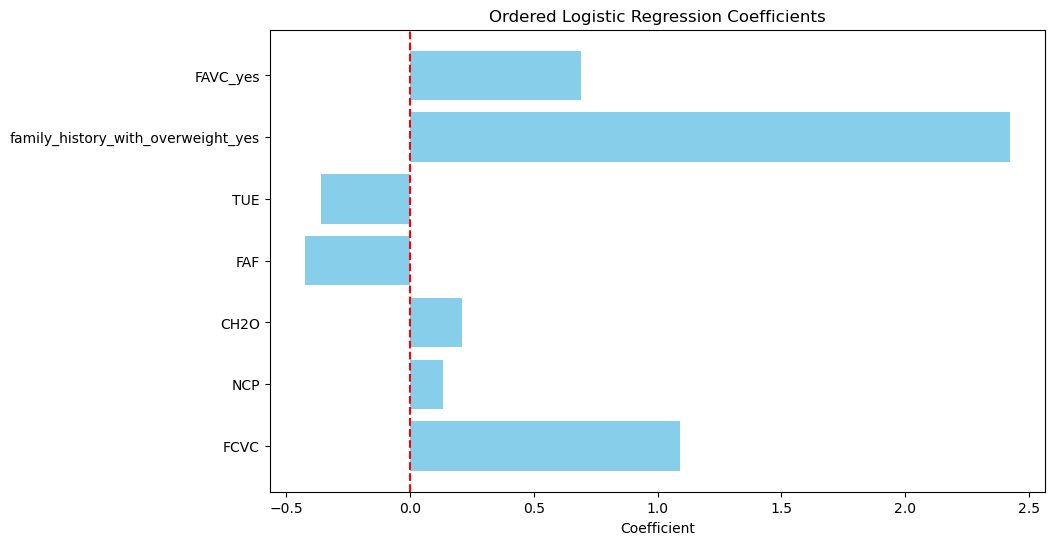

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

# 順序回帰の係数データフレームを作成（例）
ordered_model_results = {
    'Variable': ['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'family_history_with_overweight_yes', 'FAVC_yes'],
    'Coefficient': [1.0917, 0.1340, 0.2118, -0.4237, -0.3575, 2.4222, 0.6901]
}
df_ordered = pd.DataFrame(ordered_model_results)

# プロット
plt.figure(figsize=(10, 6))
plt.barh(df_ordered['Variable'], df_ordered['Coefficient'], color='skyblue')
plt.axvline(x=0, color='red', linestyle='--')  # 0を基準線
plt.xlabel('Coefficient')
plt.title('Ordered Logistic Regression Coefficients')
plt.show()


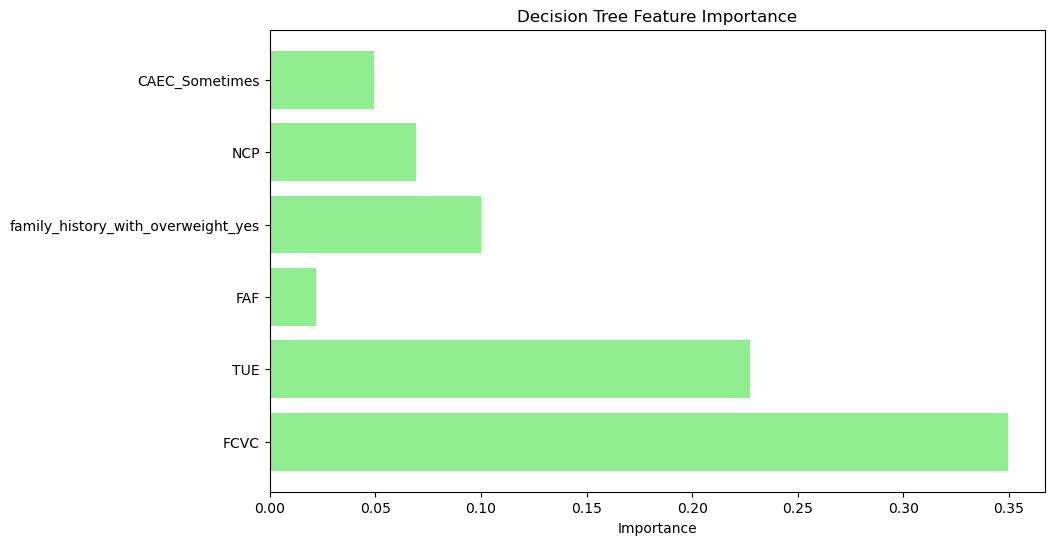

In [34]:
# 決定木の特徴量重要度（例）
tree_importances = {
    'Variable': ['FCVC', 'TUE', 'FAF','family_history_with_overweight_yes', 'NCP', 'CAEC_Sometimes'],
    'Importance': [0.349534, 0.227302, 0.021896,0.099765, 0.069101, 0.049405]
}
df_tree = pd.DataFrame(tree_importances)

# プロット
plt.figure(figsize=(10, 6))
plt.barh(df_tree['Variable'], df_tree['Importance'], color='lightgreen')
plt.xlabel('Importance')
plt.title('Decision Tree Feature Importance')
plt.show()


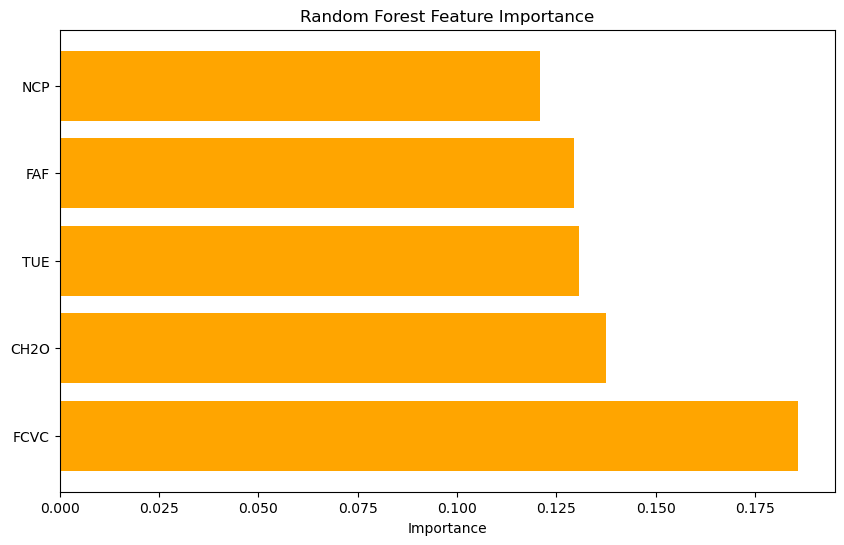

In [33]:
# ランダムフォレストの特徴量重要度（例）
rf_importances = {
    'Variable': ['FCVC', 'CH2O', 'TUE', 'FAF', 'NCP'],
    'Importance': [0.185686, 0.137417, 0.130744, 0.129305, 0.120868]
}
df_rf = pd.DataFrame(rf_importances)

# プロット
plt.figure(figsize=(10, 6))
plt.barh(df_rf['Variable'], df_rf['Importance'], color='orange')
plt.xlabel('Importance')
plt.title('Random Forest Feature Importance')
plt.show()


↑


上は、それぞれの分析の重要な特徴量を棒グラフにして可視化したもの。
比較するために作成した。


上の図からわかる通り、
FCVCが共通して肥満度に寄与していることが分かる。
つまり、身体的特徴を抜きで考えた場合、果物や野菜を食べている人ほど肥満度が高いということだ。

しかし、分析手法によって結果が異なる変数もいくつかある。

なぜ結果が異なるのか？
(1) 順序回帰 vs ツリー系モデル（決定木・ランダムフォレスト）
順序回帰は線形モデルであり、単純な線形関係を前提とします。
例: TUEが肥満度を下げると解釈されたのは、データの一部が全体の影響を引っ張ったため。
決定木やランダムフォレストは非線形関係や交互作用を考慮します。
例: TUEが肥満度を高める要因として評価されたのは、非線形な影響を反映した結果。
(2) 決定木 vs ランダムフォレスト
決定木は「単一の分岐条件」を作るため、FAFやTUEのように影響が分散する変数の重要度が低くなる傾向があります。
ランダムフォレストは多数の木を平均化するため、影響が分散する特徴量でも正確に評価されます。


上の説明は正直難しい。
まあ、つまりモデルの特性によって結果が異なるということだ。




発表の流れは以下のようにしようと思う。
発表は分析の目的から解釈まで一貫性を持たせることが何より重要

ただ気分で多変量解析をしただけのオナニー分析ではダサすぎる（ほとんどの班がこんな感じ）

「流れ」
背景: 肥満度と生活習慣の関係を明らかにする意義。

方法:
順序回帰で線形関係を確認。
決定木で分岐ルールを特定。
ランダムフォレストで非線形性を反映。

結果の比較:
共通点（例: FCVCが最重要）。
相違点（例: TUEの影響がモデルによって異なる理由を解説）。

結論:
健康的な食事や身体活動の推奨。
座りがちな生活（TUE）を減らすことの重要性。

提言: 行動変容の具体例を示す（例: 食事量管理や運動習慣の推奨）。


これである程度の一貫性が保たれるのではないか？

何か変えてほしい場所やアドバイスがあれば遠慮なく言って！！！

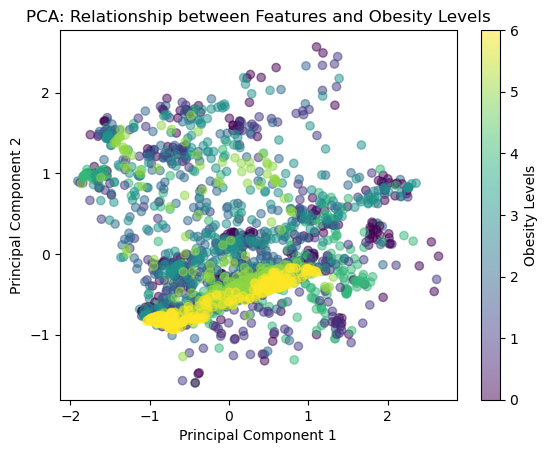

In [28]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# PCAの適用
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# 主成分得点の可視化
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y.factorize()[0], cmap='viridis', alpha=0.5)
plt.title('PCA: Relationship between Features and Obesity Levels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Obesity Levels')
plt.show()


In [29]:
print(pca.explained_variance_ratio_)

[0.22011111 0.16513756]


In [30]:
loadings = pca.components_.T
feature_contributions = pd.DataFrame(loadings, index=X.columns, columns=['PC1', 'PC2'])
print(feature_contributions)


                                         PC1       PC2
FCVC                                0.026367 -0.082938
NCP                                 0.403543 -0.837293
CH2O                                0.198821 -0.044706
FAF                                 0.878852  0.335299
TUE                                 0.084047  0.052204
family_history_with_overweight_yes -0.003170 -0.062856
FAVC_yes                           -0.042871 -0.044823
CAEC_Frequently                     0.018922  0.023076
CAEC_Sometimes                     -0.022177 -0.050966
CAEC_no                            -0.003355  0.025629
SMOKE_yes                           0.001447 -0.001857
SCC_yes                             0.016376  0.017867
CALC_Frequently                     0.012574  0.017070
CALC_Sometimes                     -0.085641 -0.295726
CALC_no                             0.073352  0.277327
MTRANS_Bike                         0.004531  0.000832
MTRANS_Motorbike                   -0.000867  0.000017
MTRANS_Pub